# Tasty Bytes - Predicting High-Traffic Recipes

### Data Validation
The data set has 947 rows and 8 columns. Preliminary check shows the following:

**recipe:** unique identifier of recipe with dtype int64. No missing values. No cleaning needed.<br>
**calories, carbohydrate, sugar, protein:** No. of calories and amount of carbohydrate, sugar and protein in grams with dtype float64. 52 missing values.>,r>
**category:** type of recipe with dtype object. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'). No missing values. No cleaning needed.<br>
**servings:** number of servings for the recipe with dtype object. It looks like it should be numeric.<br>
**high traffic:** marked "High" (dtype object) if traffic was high when this recipe was shown. 373 missing values, likely to represent "Low" traffic.


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [32]:
# Load the CSV file into a DataFrame
df = pd.read_csv("recipe_site_traffic_2212.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [33]:
df.isnull().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [34]:
# Check categorical variables for duplicate values, errors and consistency
unique_categoies = df["category"].value_counts()
unique_traffic = df["high_traffic"].value_counts()
unique_servings = df["servings"].value_counts()

unique_categoies, unique_servings, unique_traffic

(Breakfast         106
 Chicken Breast     98
 Beverages          92
 Lunch/Snacks       89
 Potato             88
 Pork               84
 Vegetable          83
 Dessert            83
 Meat               79
 Chicken            74
 One Dish Meal      71
 Name: category, dtype: int64,
 4               389
 6               197
 2               183
 1               175
 4 as a snack      2
 6 as a snack      1
 Name: servings, dtype: int64,
 High    574
 Name: high_traffic, dtype: int64)

### Cleaning steps
1. Clean "servings" by extracting numeric portion and convert to int.
2. Fill missing nutritional values with the median value of the respective nutrients.
3. For completeness, fill null values under "high_traffic" with "Low".

In [35]:
# Extract numeric portion of 'servings' and convert to int
df['servings'] = df['servings'].astype(str).str.extract(r'(\d+)')[0].astype(float).astype(int)

# Fill null values in "high_traffic" with "Low" and convert to binary ("High" = 1, "Low" = 0)
df['high_traffic'].fillna('Low', inplace=True)
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)

# Fill missing nutritional values with median of the respective columns
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    df[col].fillna(df[col].median(), inplace=True)

# Check for duplicates
duplicates = df.duplicated().sum()

# Final check
duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int64  
 7   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 59.3+ KB


## Exploratory Data Analysis

The variance for the different variable varies slightly, suggesting a need for transformation / standardization before modelling.

In [36]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic
count,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,474.000000,427.846019,34.323464,8.799641,23.416283,3.477297,0.606125
std,273.519652,441.673556,42.836191,14.306785,35.486699,1.732741,0.488866
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,237.500000,114.410000,9.135000,1.795000,3.465000,2.000000,0.000000
50%,474.000000,288.550000,21.480000,4.550000,10.800000,4.000000,1.000000
75%,710.500000,576.225000,42.590000,9.285000,28.530000,4.000000,1.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


### 1. Distribution of calories
The distribution of calorie is right-skewed, suggesting that most recipes have lower calorie counts, with a few outliers having very high calories. This indicates that most recipes are relatively low-calorie, with a small number of high-calorie recipes.

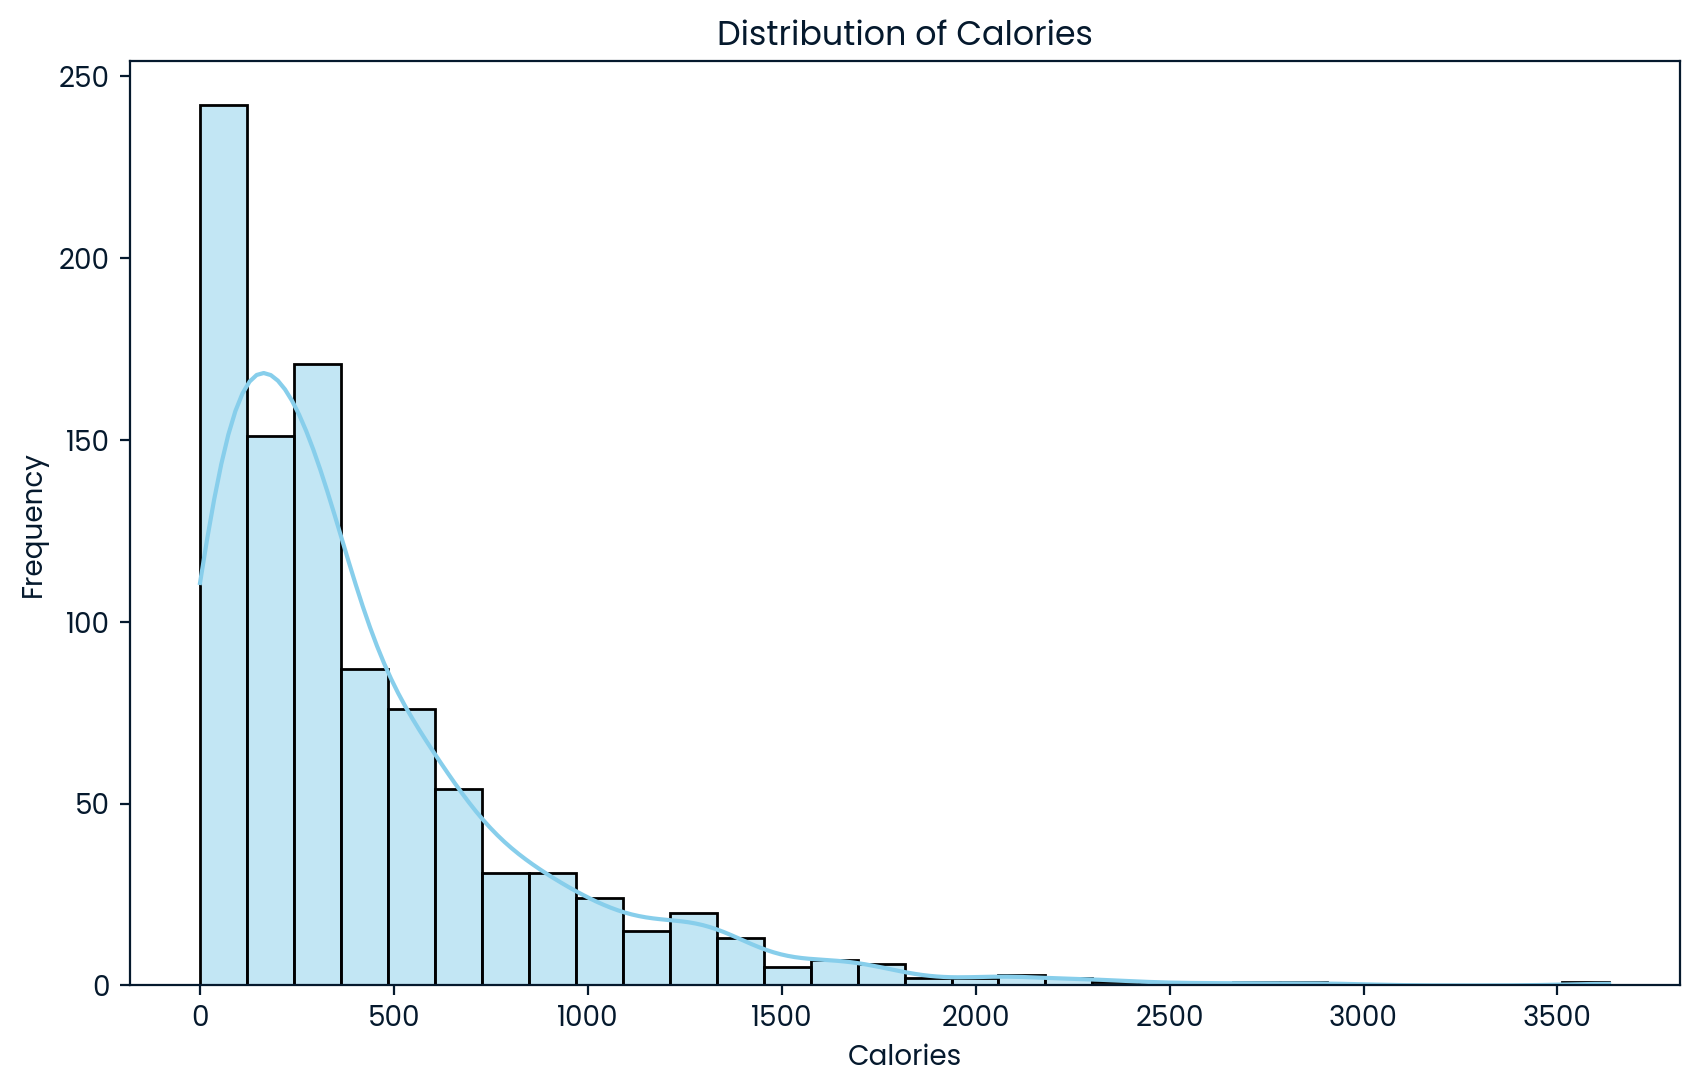

In [37]:
# Distribution of calorie
plt.figure(figsize=(10, 6))
sns.histplot(df['calories'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

### 2. Recipe category count
The dataset contains recipes from various categories, with some categories (e.g., "Breakfast", "Chicken Breast") being more frequent than others. This indicates that certain types of recipes are more common in the dataset.

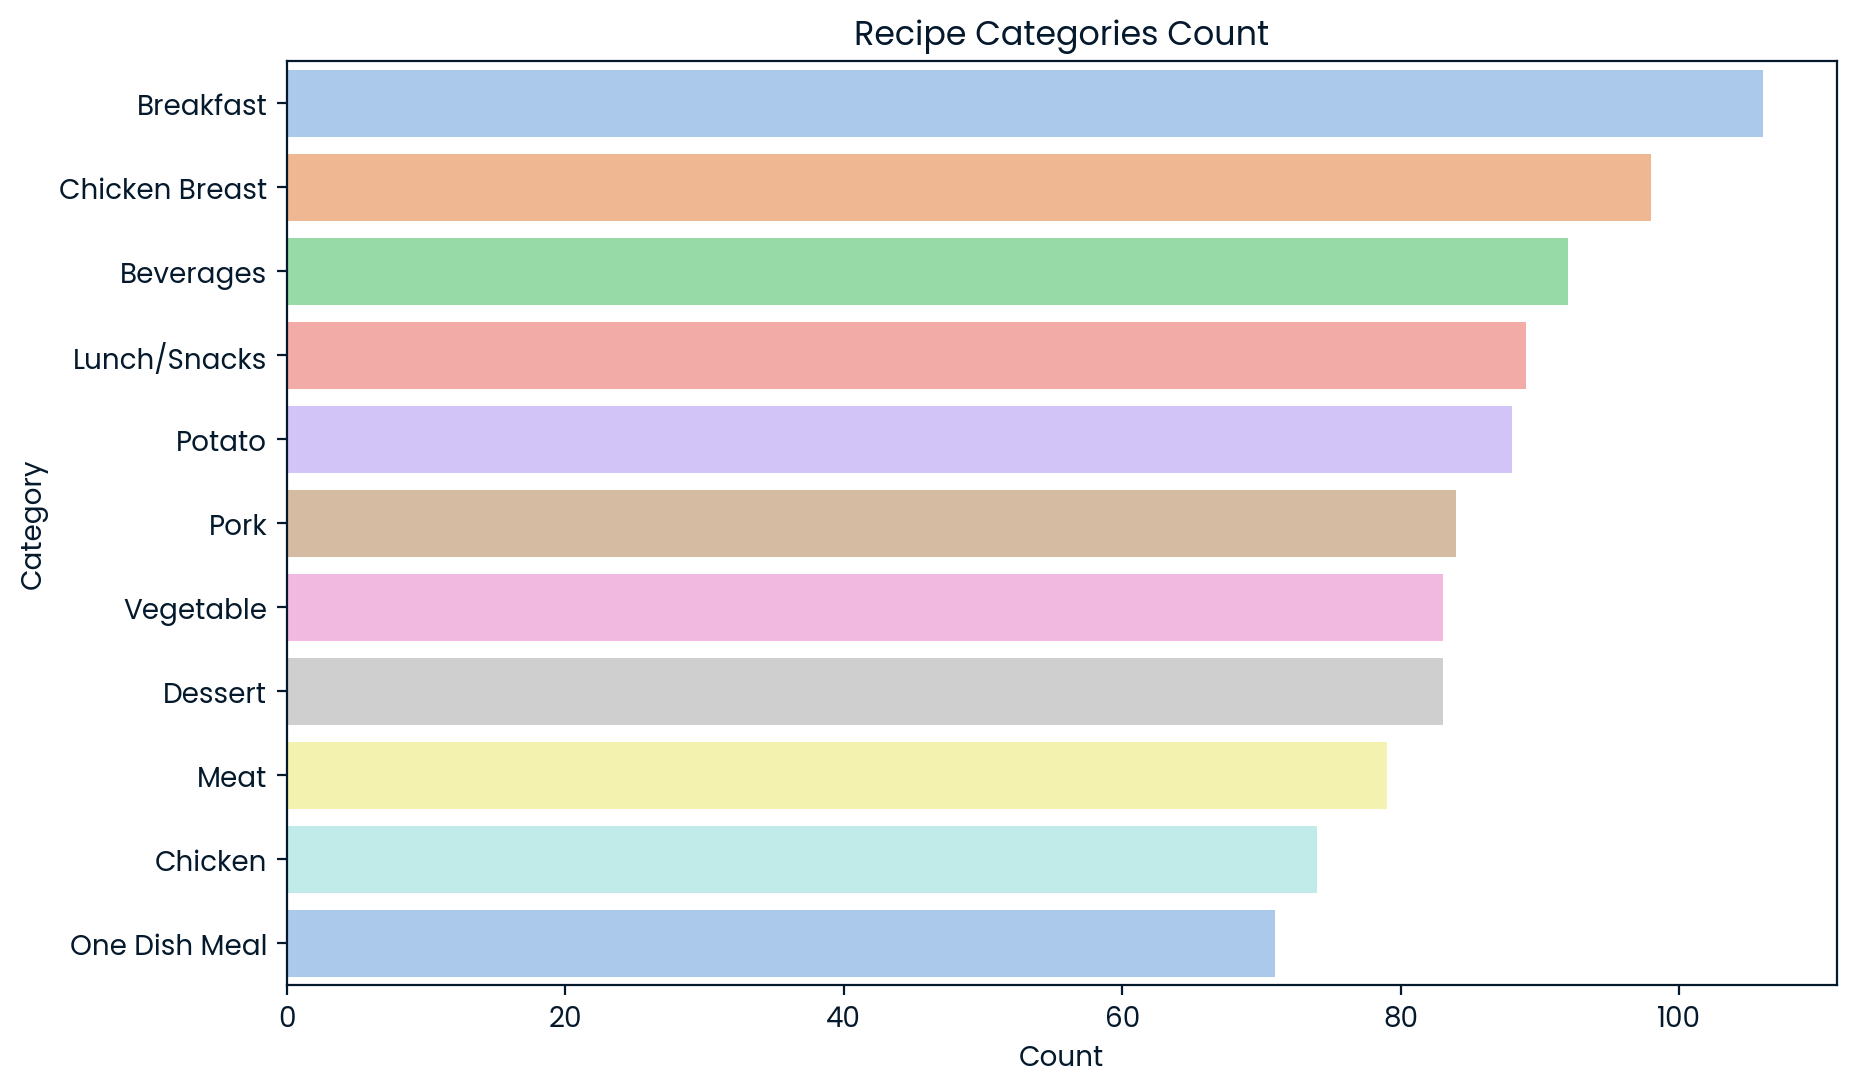

In [38]:
# Bar plot of recipe categories
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='pastel')
plt.title('Recipe Categories Count')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

### 3. Spread of carbohydrate, protein, sugar
**Carbohydrate:** The spread is wide, with many outliers on the higher end. This suggests that some recipes are very high in carbohydrates.<br>
**Protein:** The spread is narrower compared to carbohydrates, with fewer outliers. Most recipes have moderate protein content.<br>
**Sugar:** The spread is relatively narrow, but there are some outliers with very high sugar content.

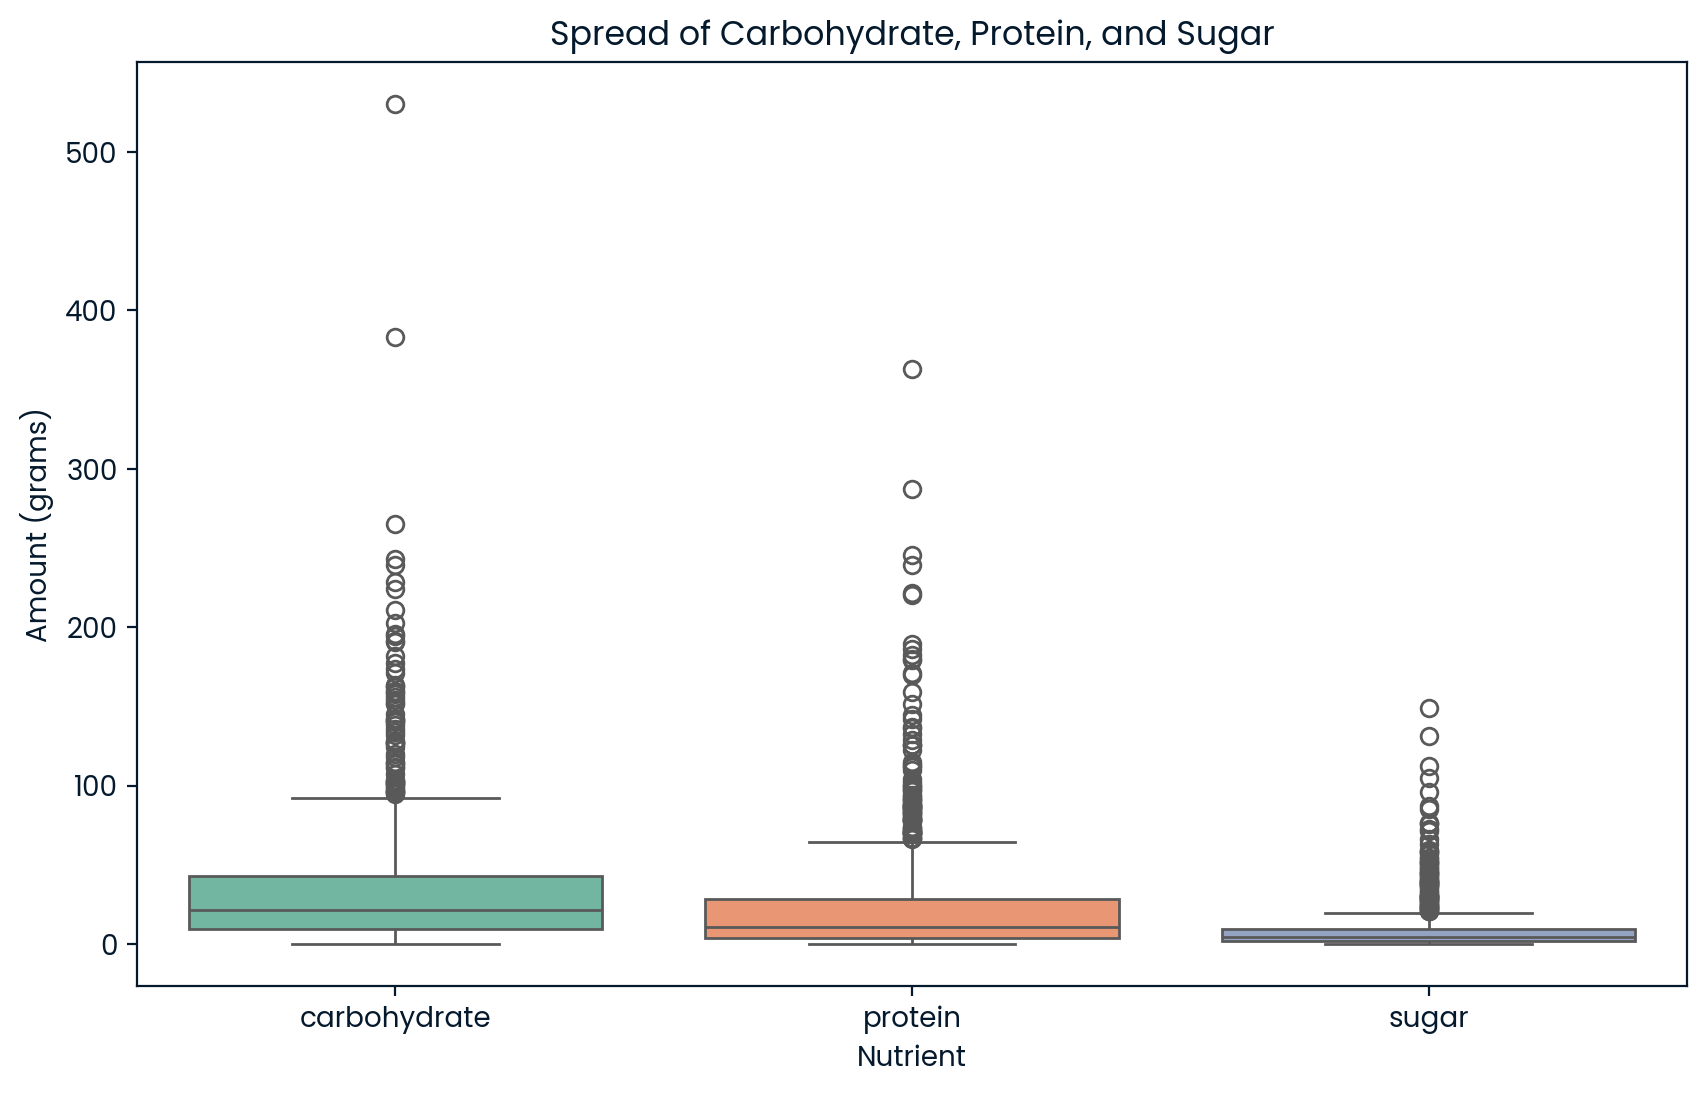

In [39]:
# boxplot for carbohydrate, protein, sugar
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['carbohydrate', 'protein', 'sugar']], palette='Set2')
plt.title('Spread of Carbohydrate, Protein, and Sugar')
plt.xlabel('Nutrient')
plt.ylabel('Amount (grams)')
plt.show()

### 4. Traffic VS calories
"High" traffic recipes tend to have more varied calorie counts, but not dramatically different from "Low".

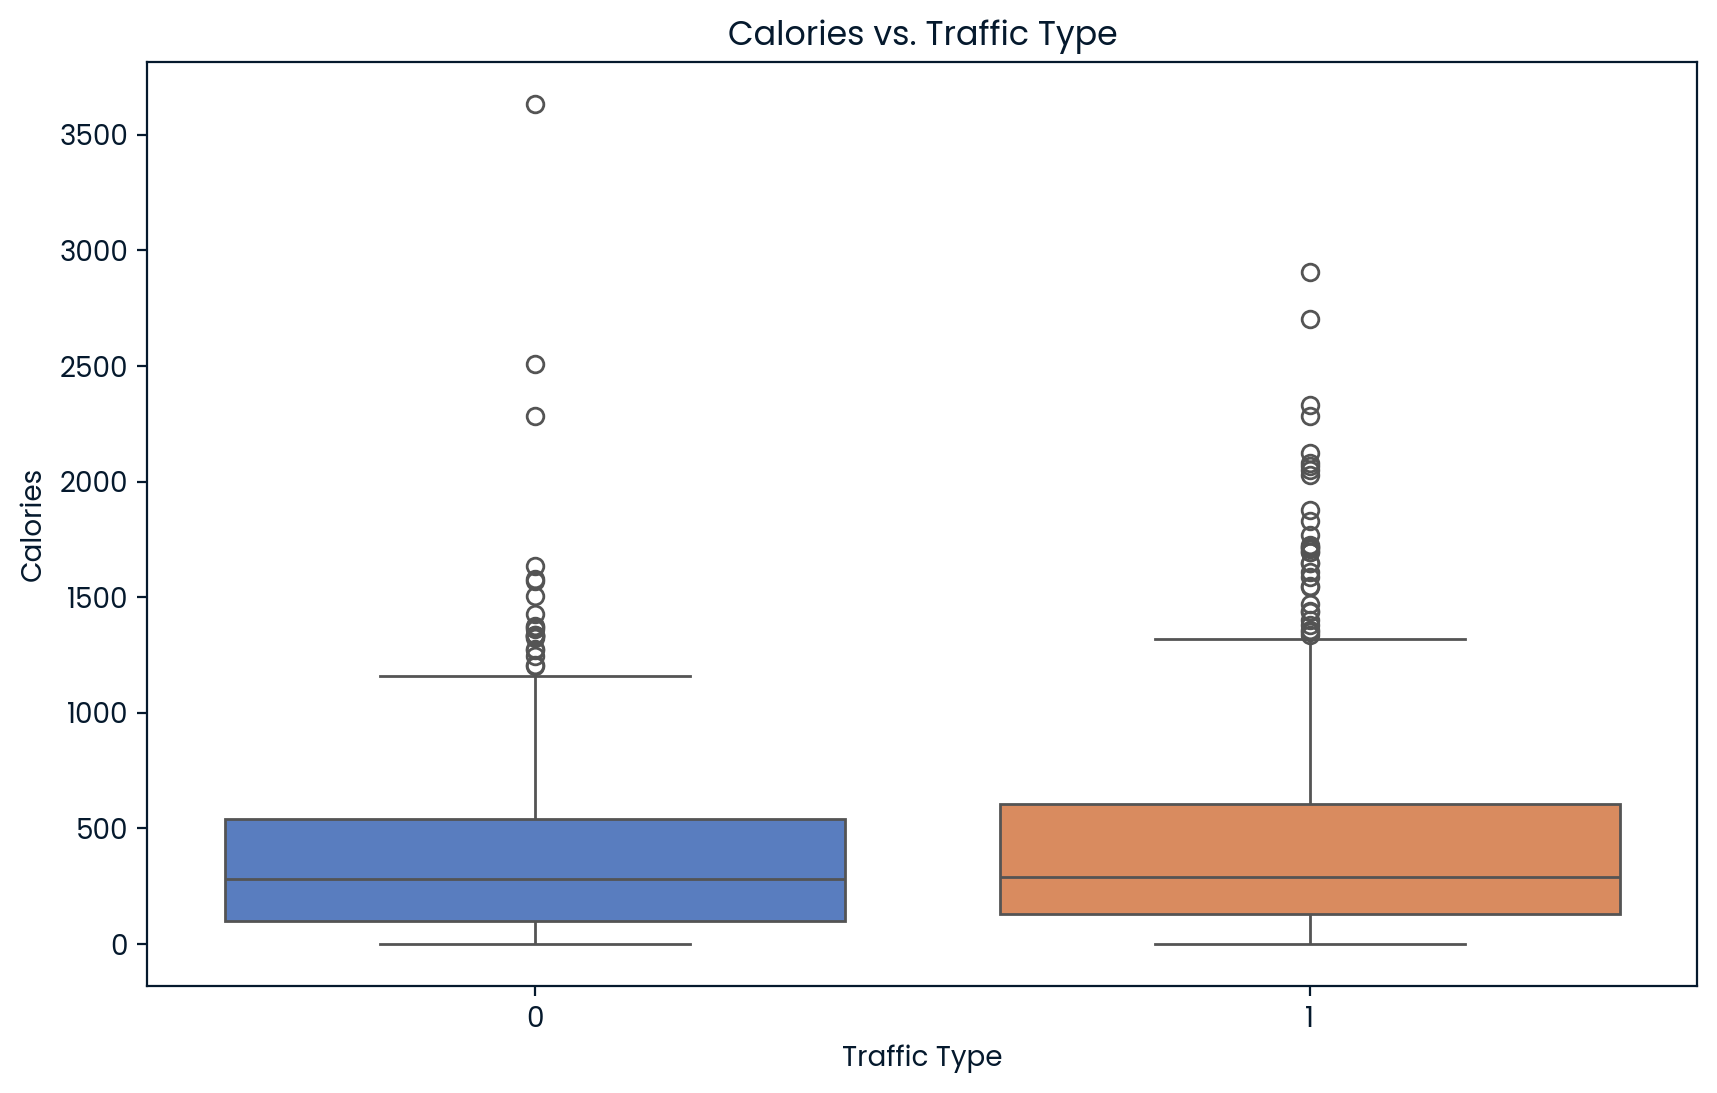

In [40]:
# Calories vs. Traffic
plt.figure(figsize=(10, 6))
sns.boxplot(x='high_traffic', y='calories', data=df, palette='muted')
plt.title('Calories vs. Traffic Type')
plt.xlabel('Traffic Type')
plt.ylabel('Calories')
plt.show()

### 5. Heatmap of correlation matrix

The heatmap shows correlations between numerical variables (e.g., calories, carbohydrate, sugar, protein). There is a moderate positive correlation between calories and protein, as seen in the scatter plot. Other correlations (e.g., carbohydrate and sugar) are also visible, indicating relationships between nutritional components.

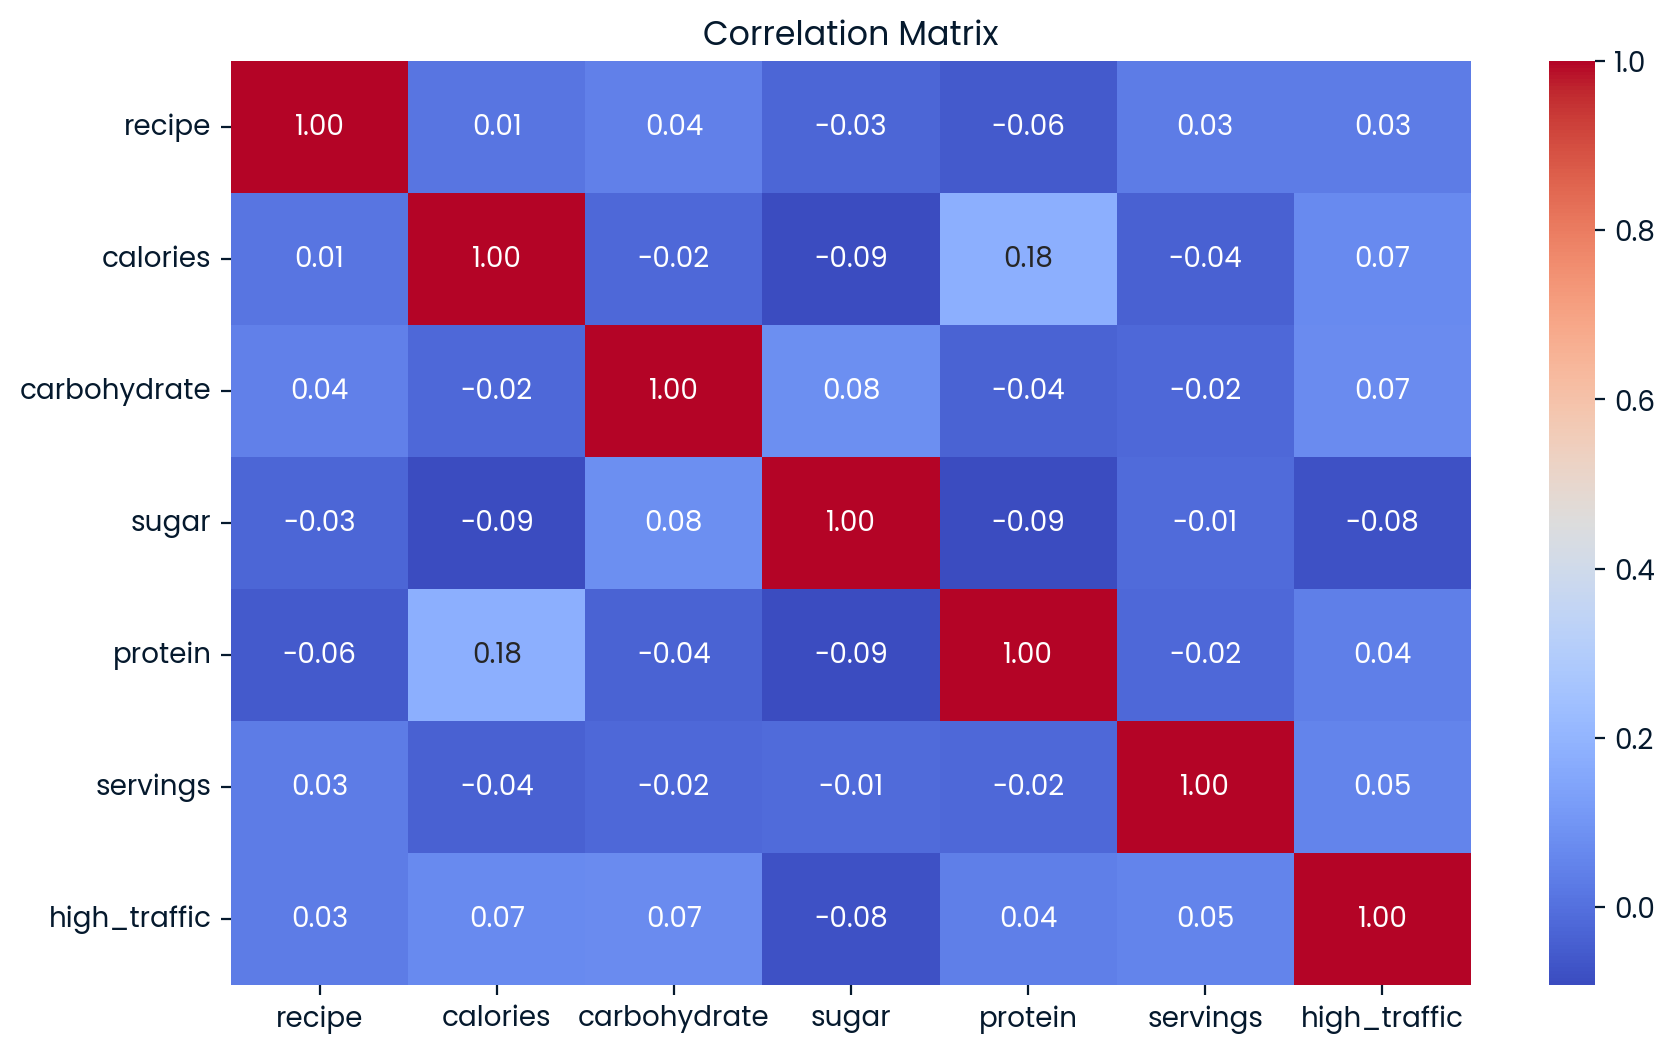

In [41]:
# Heatmap of correlation matrix
plt.figure(figsize=(10, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Model Fitting and Evaluation

Predicting which recipes will lead to high traffic is a classification problem. Logistic Regression will be the base model as it is a simple, interpretable and computationally efficient algorithm. It will serve as a good baseline model to cocmpare more complex models against. Random Forest is the comparison model as it can capture non-linear relationships and interactions between features, which Logistic Regression cannot. Random Forest can also provide insights into feature importance, which can help understand which features contribute most to the prediction.

For evaluation, we will based on the classification reports and confusion matrices to select the model with the better performance.

In [42]:
# Feature engineering: convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['category'], drop_first=True)

# Define features X and target y
X = df.drop(columns=['high_traffic', 'recipe'], axis=1)
y = df['high_traffic']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression

In [43]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:")
print(accuracy_score(y_test, y_pred_log_reg))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))

Logistic Regression Accuracy:
0.7543859649122807
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       107
           1       0.80      0.80      0.80       178

    accuracy                           0.75       285
   macro avg       0.74      0.74      0.74       285
weighted avg       0.75      0.75      0.75       285

Logistic Regression Confusion Matrix:
[[ 72  35]
 [ 35 143]]


Random Forest

In [44]:
# Initialize the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:")
print(accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy:
0.7017543859649122
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       107
           1       0.76      0.77      0.76       178

    accuracy                           0.70       285
   macro avg       0.68      0.68      0.68       285
weighted avg       0.70      0.70      0.70       285

Random Forest Confusion Matrix:
[[ 63  44]
 [ 41 137]]


## Performance Metrics and Evaluation

## Performance Metrics

1. Precision - Logistic Regression (Class 0: 0.67, Class 1: 0.80) has higher precision for both classes, meaning it makes fewer false positive predictions compared to Random Forest (Class 0: 0.61, Class 1: 0.76).
2. Recall - Logistic Regression has a higher recall for Class 1 (0.80), suggesting it correctly identifies more instances of Class 1 compared to Random Forest (0.77). 
3. Accuracy (TP + TN / TP + FP + TN + FN) - Logistic Regression has higher accuracy (75%), meaning it correctly predicts more instances overall compared to Random Forest (70%).

## Performance Evaluation
The Logistic Regression model has fewer false positives and false negatives compared to Random Forest, indicating better performance in both classes. Based on business criteria, the Logistic Regression model is able to correctly predict high traffic recipes (Recall for Class 1) 80% of the time.

## Summary of Findings

- Logistic Regression outperforms Random Forest in terms of precision, recall, F1-score, and accuracy.

- Logistic Regression has fewer misclassifications (false positives and false negatives) compared to Random Forest.

- Random Forest, while still performing reasonably well, does not provide a significant improvement over Logistic Regression in this case. This could be due to the dataset’s characteristics (e.g., linear decision boundaries or fewer complex interactions between features).

- Logistic Regression is able to correctly predict high traffic recipes (Recall for Class 1) 80% of the time.

## Recommendations

- Adopt Logistic Regression as the primary model as it outperforms the Random Forest in terms of precision, recall and accuracy. It is more effective in predicting high-traffic recipes, and also has fewer misclassifications (false positives and false negatives), which reduces the risk of incorrect predictions.
- Continuously monitor model performance over time to ensure it remains effective as new data comes in. Track key metrics and detect any degradation in performance.
- Explore feature engineering for further improvements to the model. Test other models to ensure no better alternative exists.
- Since model achieves 80% recall for high-traffic recipes (Class 1), the business can :
    - Prioritize marketing efforts for high-traffic recipes.
    - Optimize inventory management for ingredients used in these recipes.
    - Improve customer satisfaction by promoting popular recipes.